# Logistic Regression #2: Multi-Sauce Recommendation System

## Objective
Build a recommendation system that predicts which sauce(s) a customer is likely to purchase based on their cart contents.

We train **one model per sauce** and compare their performance.

### Available Sauces:
- Crazy Sauce
- Cheddar Sauce
- Extra Cheddar Sauce
- Garlic Sauce
- Tomato Sauce
- Blueberry Sauce
- Spicy Sauce
- Pink Sauce

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add src to path for module imports
PROJECT_ROOT = Path(os.path.abspath('')).parent
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

from data_loader import load_raw_data, SAUCES
from preprocessing import prepare_lr_data, normalize_features, get_feature_names
from models.logistic_regression import LogisticRegression
from models.evaluation import (
    accuracy, precision, recall, f1_score, 
    confusion_matrix, classification_report
)

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

print("Available sauces:")
for sauce in SAUCES:
    print(f"  - {sauce}")

Available sauces:
  - Crazy Sauce
  - Cheddar Sauce
  - Extra Cheddar Sauce
  - Garlic Sauce
  - Tomato Sauce
  - Blueberry Sauce
  - Spicy Sauce
  - Pink Sauce


## 1. Load Data

In [ ]:
# Load raw data
DATA_PATH = Path('../data/raw/ap_dataset.csv')
df = load_raw_data(str(DATA_PATH))

print(f"Dataset: {len(df)} rows, {df['id_bon'].nunique()} receipts")

Dataset: 28039 rows, 7869 receipts


In [3]:
# Check sauce distribution
sauce_counts = {}
total_receipts = df['id_bon'].nunique()

for sauce in SAUCES:
    count = df[df['retail_product_name'] == sauce]['id_bon'].nunique()
    sauce_counts[sauce] = {
        'count': count,
        'percentage': 100 * count / total_receipts
    }

sauce_df = pd.DataFrame(sauce_counts).T
sauce_df = sauce_df.sort_values('count', ascending=False)
print("Sauce Purchase Rates:")
sauce_df

Sauce Purchase Rates:


,count,percentage
Crazy Sauce,1594.0,20.256704
Cheddar Sauce,1032.0,13.114754
Garlic Sauce,736.0,9.353158
Blueberry Sauce,711.0,9.035456
Spicy Sauce,382.0,4.854492
Tomato Sauce,209.0,2.655992
Pink Sauce,147.0,1.868090
Extra Cheddar Sauce,24.0,0.304994


## 2. Train Models for Each Sauce

In [4]:
from sklearn.model_selection import train_test_split

# Store results
models = {}
results = {}

for sauce in SAUCES:
    print(f"\n{'='*60}")
    print(f"Training model for: {sauce}")
    print('='*60)
    
    # Prepare data (no filter - all receipts)
    try:
        X, y, features_df = prepare_lr_data(
            df,
            target_sauce=sauce,
            filter_product=None,  # All receipts
            exclude_all_sauces=True
        )
    except Exception as e:
        print(f"  Error preparing data: {e}")
        continue
    
    # Check if we have enough positive samples
    if y.sum() < 10:
        print(f"  Skipping - not enough positive samples ({y.sum()})")
        continue
    
    print(f"  Samples: {len(y)}, Positive: {y.sum()} ({100*y.mean():.1f}%)")
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Normalize
    X_train_norm, mean, std = normalize_features(X_train)
    X_test_norm, _, _ = normalize_features(X_test, mean=mean, std=std)
    
    # Train model
    model = LogisticRegression(
        learning_rate=0.1,
        n_iterations=500,
        regularization=0.01,
        verbose=False
    )
    model.fit(X_train_norm, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test_norm)
    
    report = classification_report(y_test, y_pred)
    
    print(f"  Accuracy:  {report['accuracy']:.4f}")
    print(f"  Precision: {report['precision']:.4f}")
    print(f"  Recall:    {report['recall']:.4f}")
    print(f"  F1 Score:  {report['f1_score']:.4f}")
    
    # Store
    models[sauce] = {
        'model': model,
        'mean': mean,
        'std': std,
        'feature_names': get_feature_names(features_df)
    }
    results[sauce] = {
        'samples': len(y),
        'positive_rate': y.mean(),
        **report
    }


Training model for: Crazy Sauce
  Samples: 7869, Positive: 1594 (20.3%)
  Accuracy:  0.8424
  Precision: 0.6291
  Recall:    0.5423
  F1 Score:  0.5825

Training model for: Cheddar Sauce
  Samples: 7869, Positive: 1032 (13.1%)
  Accuracy:  0.8698
  Precision: 0.5094
  Recall:    0.1311
  F1 Score:  0.2085

Training model for: Extra Cheddar Sauce
  Samples: 7869, Positive: 24 (0.3%)
  Accuracy:  0.9968
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

Training model for: Garlic Sauce
  Samples: 7869, Positive: 736 (9.4%)
  Accuracy:  0.9041
  Precision: 0.4091
  Recall:    0.0612
  F1 Score:  0.1065

Training model for: Tomato Sauce
  Samples: 7869, Positive: 209 (2.7%)
  Accuracy:  0.9733
  Precision: 0.0000
  Recall:    0.0000
  F1 Score:  0.0000

Training model for: Blueberry Sauce
  Samples: 7869, Positive: 711 (9.0%)
  Accuracy:  0.9111
  Precision: 0.5294
  Recall:    0.1268
  F1 Score:  0.2045

Training model for: Spicy Sauce
  Samples: 7869, Positive: 382 (4.9%)
  Ac

## 3. Compare Model Performance

In [5]:
# Create comparison DataFrame
comparison_data = []
for sauce, res in results.items():
    comparison_data.append({
        'Sauce': sauce,
        'Base Rate': res['positive_rate'],
        'Accuracy': res['accuracy'],
        'Precision': res['precision'],
        'Recall': res['recall'],
        'F1 Score': res['f1_score'] 
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1 Score', ascending=False)

print("Model Performance Comparison:")
comparison_df.round(4)

Model Performance Comparison:


,Sauce,Base Rate,Accuracy,Precision,Recall,F1 Score
0,Crazy Sauce,0.2026,0.8424,0.6291,0.5423,0.5825
1,Cheddar Sauce,0.1311,0.8698,0.5094,0.1311,0.2085
5,Blueberry Sauce,0.0904,0.9111,0.5294,0.1268,0.2045
3,Garlic Sauce,0.0935,0.9041,0.4091,0.0612,0.1065
6,Spicy Sauce,0.0485,0.9524,0.6667,0.0263,0.0506
2,Extra Cheddar Sauce,0.0030,0.9968,0.0000,0.0000,0.0000
4,Tomato Sauce,0.0266,0.9733,0.0000,0.0000,0.0000
7,Pink Sauce,0.0187,0.9816,0.0000,0.0000,0.0000


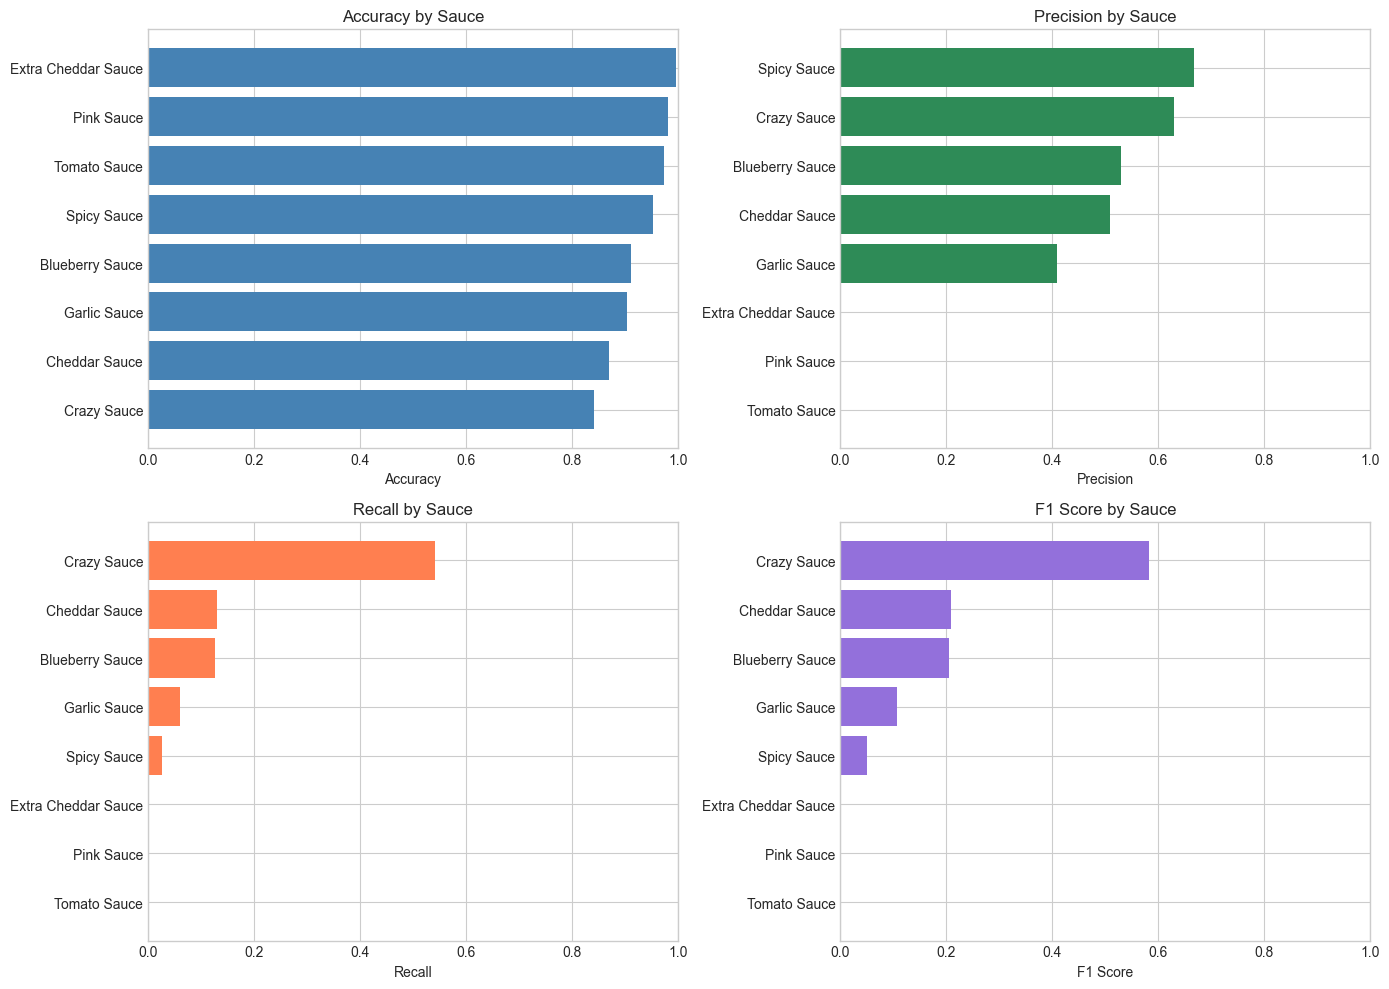

In [6]:
# Visualization - metrics comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
colors = ['steelblue', 'seagreen', 'coral', 'mediumpurple']

for ax, metric, color in zip(axes.flatten(), metrics, colors):
    data = comparison_df.sort_values(metric, ascending=True)
    ax.barh(data['Sauce'], data[metric], color=color)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} by Sauce')
    ax.set_xlim(0, 1)
    
plt.tight_layout()
plt.savefig('../results/lr2_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

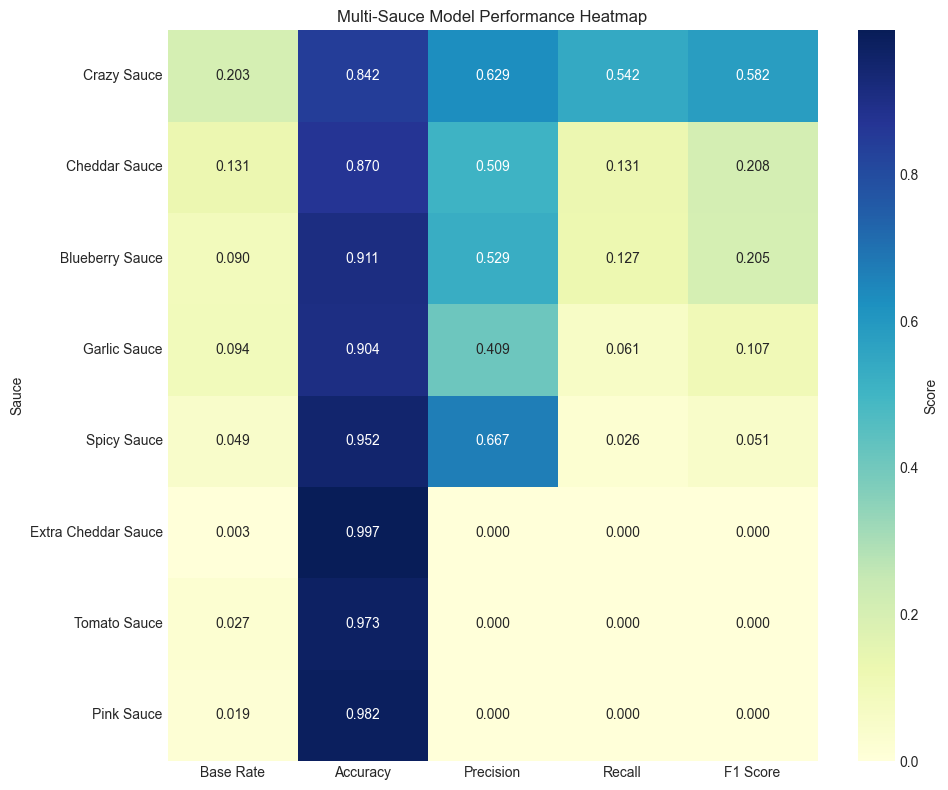

In [7]:
# Heatmap of all metrics
fig, ax = plt.subplots(figsize=(10, 8))

heatmap_data = comparison_df.set_index('Sauce')[['Base Rate', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlGnBu', ax=ax,
            cbar_kws={'label': 'Score'})
ax.set_title('Multi-Sauce Model Performance Heatmap')
plt.tight_layout()
plt.savefig('../results/lr2_performance_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Feature Importance Analysis

In [8]:
# Top features for each sauce
print("Top 5 Features for Each Sauce Model:")
print("=" * 70)

for sauce, model_data in models.items():
    model = model_data['model']
    feature_names = model_data['feature_names']
    
    importance = model.get_feature_importance(feature_names)
    top_5 = list(importance.items())[:5]
    
    print(f"\n{sauce}:")
    for name, data in top_5:
        direction = "+" if data['weight'] > 0 else "-"
        print(f"  {direction} {name}: {data['weight']:+.4f}")

Top 5 Features for Each Sauce Model:

Crazy Sauce:
  + distinct_products: +0.5934
  + has_Crazy Schnitzel: +0.5562
  - has_Viennese Schnitzel: -0.3908
  + has_Mac & cheease: +0.3144
  + cart_size: +0.2383

Cheddar Sauce:
  + distinct_products: +0.4544
  + cart_size: +0.2973
  + has_Breaded Chicken Schnitzel: +0.2821
  - has_Mac & Cheese with Crispy Bacon: -0.2203
  - has_Crazy Fries with Cheddar Sauce: -0.2080

Extra Cheddar Sauce:
  + has_Extra bacon: +0.0705
  + has_Baked potatoes: +0.0705
  + cart_size: +0.0674
  - has_Mac & cheease: -0.0607
  + distinct_products: +0.0578

Garlic Sauce:
  + distinct_products: +0.5027
  + cart_size: +0.3728
  - has_Mac & Cheese with Crispy Bacon: -0.2253
  + has_Breaded Chicken Schnitzel: +0.2127
  - has_Packaging: -0.1738

Tomato Sauce:
  + distinct_products: +0.2045
  + cart_size: +0.1763
  + has_Aqua Carpatica Plata 0.5L: +0.1400
  - has_Viennese Schnitzel: -0.1334
  + has_Breaded Pork Schnitzel: +0.1329

Blueberry Sauce:
  + distinct_products: +0

In [9]:
# Feature importance heatmap for top features
# Get union of top 10 features across all models
all_top_features = set()
for sauce, model_data in models.items():
    importance = model_data['model'].get_feature_importance(model_data['feature_names'])
    all_top_features.update(list(importance.keys())[:10])

all_top_features = list(all_top_features)

# Create weight matrix
weight_matrix = pd.DataFrame(index=all_top_features, columns=list(models.keys()))

for sauce, model_data in models.items():
    importance = model_data['model'].get_feature_importance(model_data['feature_names'])
    for feat in all_top_features:
        if feat in importance:
            weight_matrix.loc[feat, sauce] = importance[feat]['weight']
        else:
            weight_matrix.loc[feat, sauce] = 0

weight_matrix = weight_matrix.astype(float)

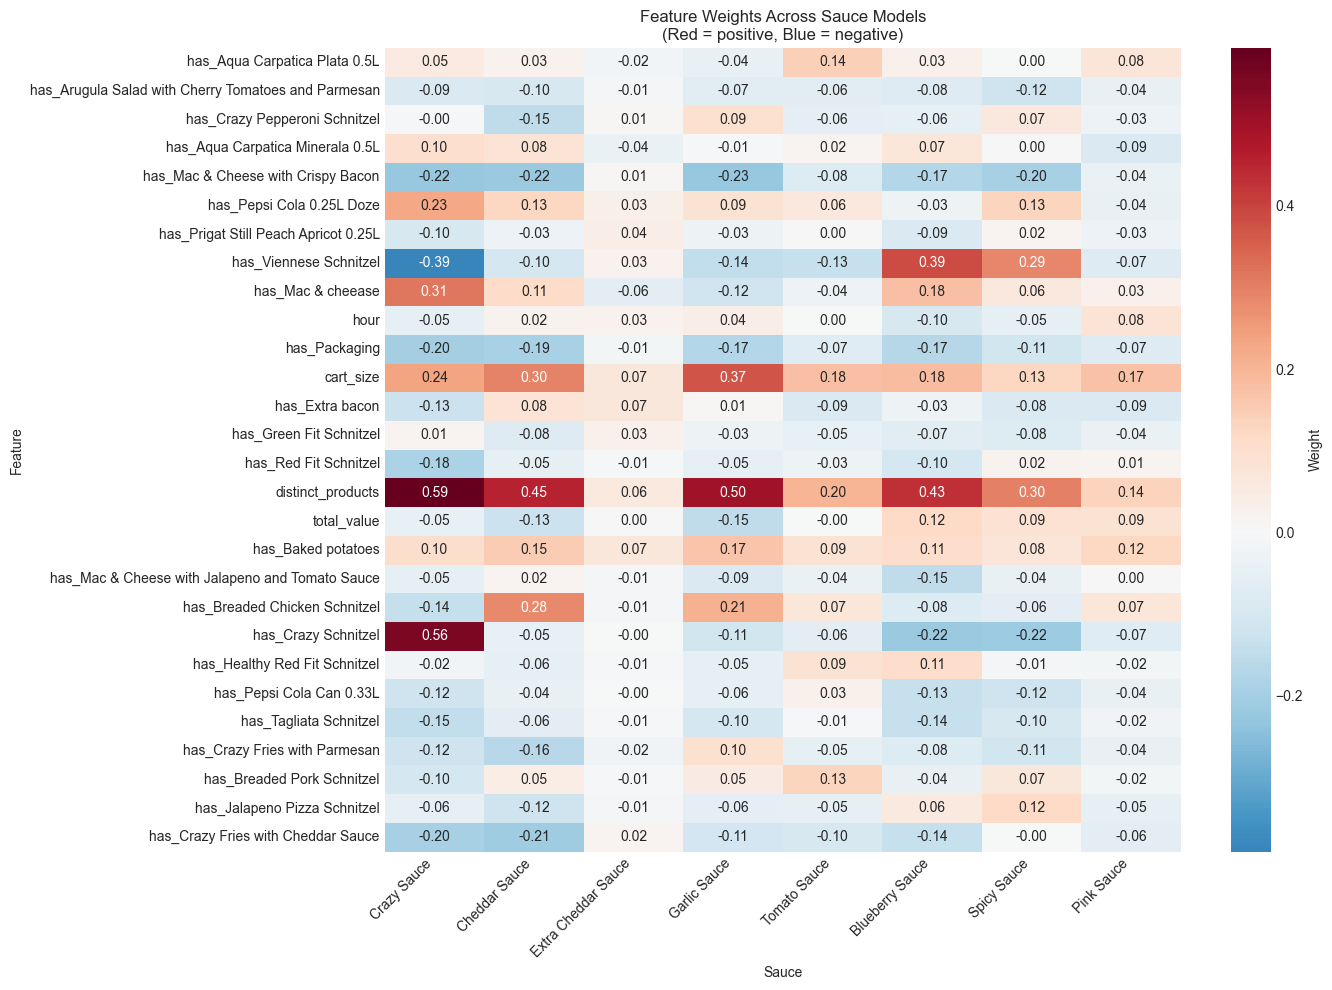

In [10]:
# Visualize feature weights across sauces
fig, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(weight_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax,
            cbar_kws={'label': 'Weight'})
ax.set_title('Feature Weights Across Sauce Models\n(Red = positive, Blue = negative)')
ax.set_xlabel('Sauce')
ax.set_ylabel('Feature')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../results/lr2_feature_weights_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Recommendation Function

In [11]:
def recommend_sauces(cart_features, models, top_n=3):
    """
    Recommend top N sauces based on cart features.
    
    Args:
        cart_features: Dictionary of feature_name -> value
        models: Dictionary of sauce -> model info
        top_n: Number of sauces to recommend
        
    Returns:
        List of (sauce_name, probability) tuples
    """
    predictions = []
    
    for sauce, model_data in models.items():
        model = model_data['model']
        mean = model_data['mean']
        std = model_data['std']
        feature_names = model_data['feature_names']
        
        # Create feature vector
        X = np.zeros(len(feature_names))
        for i, feat in enumerate(feature_names):
            if feat in cart_features:
                X[i] = cart_features[feat]
        
        # Normalize
        X_norm = (X - mean) / std
        
        # Predict
        prob = model.predict_proba(X_norm.reshape(1, -1))[0]
        predictions.append((sauce, prob))
    
    # Sort by probability
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:top_n]

# Example usage
example_cart = {
    'has_Crazy Schnitzel': 1,
    'has_French fries': 1,
    'cart_size': 3,
    'total_value': 50,
    'hour': 13,
    'is_weekend': 0
}

print("Example Recommendation:")
print(f"Cart: {example_cart}")
print("\nRecommended Sauces:")
recommendations = recommend_sauces(example_cart, models, top_n=3)
for sauce, prob in recommendations:
    print(f"  {sauce}: {prob:.1%} probability")

Example Recommendation:
Cart: {'has_Crazy Schnitzel': 1, 'has_French fries': 1, 'cart_size': 3, 'total_value': 50, 'hour': 13, 'is_weekend': 0}

Recommended Sauces:
  Crazy Sauce: 21.7% probability
  Cheddar Sauce: 3.9% probability
  Garlic Sauce: 3.9% probability


## 5.1 Hit@K Evaluation for Sauce Recommendation

Evaluate the recommendation system using Hit@K metric: for receipts that contain at least one sauce, check if the actual sauce(s) appear in the top-K recommendations.

In [12]:
# Prepare test data for Hit@K evaluation
# Split receipts into train/test
from sklearn.model_selection import train_test_split

all_receipt_ids = df['id_bon'].unique()
train_ids, test_ids = train_test_split(all_receipt_ids, test_size=0.2, random_state=42)

print(f"Test receipts: {len(test_ids)}")

# Get receipts that have at least one sauce
test_receipts_with_sauce = []
for receipt_id in test_ids:
    receipt_products = df[df['id_bon'] == receipt_id]['retail_product_name'].tolist()
    sauces_in_receipt = [p for p in receipt_products if p in SAUCES]
    if sauces_in_receipt:
        test_receipts_with_sauce.append({
            'id': receipt_id,
            'products': receipt_products,
            'sauces': sauces_in_receipt
        })

print(f"Test receipts with sauce: {len(test_receipts_with_sauce)}")

Test receipts: 1574
Test receipts with sauce: 818


In [13]:
# Evaluate Hit@K for our LR recommendation system
def evaluate_sauce_recommendations(test_receipts, models, df, k_values=[1, 3, 5]):
    """
    Evaluate sauce recommendations using Hit@K.
    
    For each test receipt with sauce:
    1. Build features WITHOUT the sauce
    2. Get top-K recommendations
    3. Check if actual sauce is in top-K
    """
    results = {k: {'hits': 0, 'total': 0} for k in k_values}
    
    for receipt in test_receipts:
        receipt_id = receipt['id']
        actual_sauces = receipt['sauces']
        
        # Build cart features (excluding sauces)
        receipt_df = df[df['id_bon'] == receipt_id]
        
        cart_features = {
            'cart_size': len(receipt_df),
            'distinct_products': receipt_df['retail_product_name'].nunique(),
            'total_value': receipt_df['SalePriceWithVAT'].sum(),
        }
        
        # Add temporal features
        first_row = receipt_df.iloc[0]
        if 'hour' in first_row:
            cart_features['hour'] = first_row['hour']
        if 'day_of_week' in first_row:
            cart_features['day_of_week'] = first_row['day_of_week']
        if 'is_weekend' in first_row:
            cart_features['is_weekend'] = first_row['is_weekend']
        
        # Add product features (excluding sauces)
        for product in receipt_df['retail_product_name'].unique():
            if product not in SAUCES:
                cart_features[f'has_{product}'] = 1
        
        # Get recommendations
        recommendations = recommend_sauces(cart_features, models, top_n=max(k_values))
        recommended_sauces = [s for s, _ in recommendations]
        
        # Check Hit@K
        for k in k_values:
            results[k]['total'] += 1
            top_k_sauces = recommended_sauces[:k]
            if any(sauce in top_k_sauces for sauce in actual_sauces):
                results[k]['hits'] += 1
    
    # Calculate hit rates
    hit_rates = {k: results[k]['hits'] / results[k]['total'] if results[k]['total'] > 0 else 0 
                 for k in k_values}
    
    return hit_rates, results

# Run evaluation
print("Evaluating LR Sauce Recommendation System...")
lr_hit_rates, lr_results = evaluate_sauce_recommendations(
    test_receipts_with_sauce[:500],  # Sample for speed
    models, df, k_values=[1, 3, 5]
)

print(f"\nLR Recommendation Results:")
for k, rate in lr_hit_rates.items():
    print(f"  Hit@{k}: {rate:.4f} ({lr_results[k]['hits']}/{lr_results[k]['total']})")

Evaluating LR Sauce Recommendation System...

LR Recommendation Results:
  Hit@1: 0.4320 (216/500)
  Hit@3: 0.7720 (386/500)
  Hit@5: 0.9400 (470/500)


In [14]:
# Popularity Baseline for comparison
# Calculate sauce popularity from training data
train_df = df[df['id_bon'].isin(train_ids)]
sauce_popularity = {}
total_train_receipts = train_df['id_bon'].nunique()

for sauce in SAUCES:
    count = train_df[train_df['retail_product_name'] == sauce]['id_bon'].nunique()
    sauce_popularity[sauce] = count / total_train_receipts

# Sort by popularity
popularity_ranking = sorted(sauce_popularity.items(), key=lambda x: x[1], reverse=True)
print("Sauce Popularity (Baseline Ranking):")
for sauce, pop in popularity_ranking:
    print(f"  {sauce}: {pop:.2%}")

# Evaluate popularity baseline
def evaluate_popularity_baseline(test_receipts, popularity_ranking, k_values=[1, 3, 5]):
    """Baseline: always recommend by global popularity."""
    results = {k: {'hits': 0, 'total': 0} for k in k_values}
    
    top_sauces_by_pop = [s for s, _ in popularity_ranking]
    
    for receipt in test_receipts:
        actual_sauces = receipt['sauces']
        
        for k in k_values:
            results[k]['total'] += 1
            if any(sauce in top_sauces_by_pop[:k] for sauce in actual_sauces):
                results[k]['hits'] += 1
    
    hit_rates = {k: results[k]['hits'] / results[k]['total'] if results[k]['total'] > 0 else 0 
                 for k in k_values}
    return hit_rates, results

# Run baseline evaluation
pop_hit_rates, pop_results = evaluate_popularity_baseline(
    test_receipts_with_sauce[:500], popularity_ranking, k_values=[1, 3, 5]
)

print(f"\nPopularity Baseline Results:")
for k, rate in pop_hit_rates.items():
    print(f"  Hit@{k}: {rate:.4f} ({pop_results[k]['hits']}/{pop_results[k]['total']})")

Sauce Popularity (Baseline Ranking):
  Crazy Sauce: 20.48%
  Cheddar Sauce: 13.12%
  Garlic Sauce: 9.15%
  Blueberry Sauce: 9.12%
  Spicy Sauce: 4.88%
  Tomato Sauce: 2.88%
  Pink Sauce: 1.86%
  Extra Cheddar Sauce: 0.33%

Popularity Baseline Results:
  Hit@1: 0.3780 (189/500)
  Hit@3: 0.7440 (372/500)
  Hit@5: 0.9320 (466/500)



HIT@K COMPARISON: LR vs Popularity Baseline
             Method  Hit@1  Hit@3  Hit@5
  LR Recommendation  0.432  0.772  0.940
Popularity Baseline  0.378  0.744  0.932


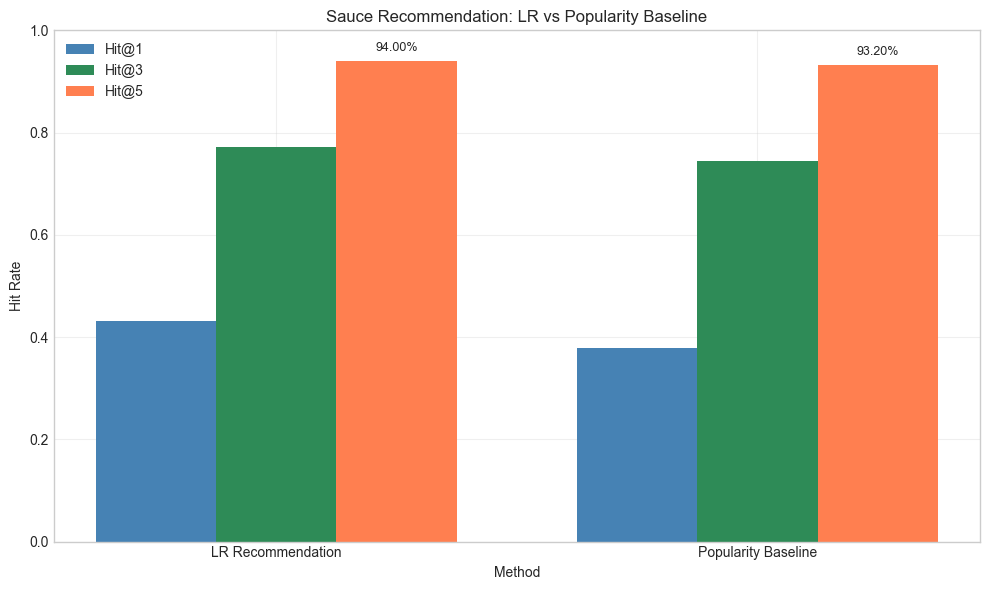

In [15]:
# Compare LR vs Popularity Baseline
comparison_hitk = pd.DataFrame({
    'Method': ['LR Recommendation', 'Popularity Baseline'],
    'Hit@1': [lr_hit_rates[1], pop_hit_rates[1]],
    'Hit@3': [lr_hit_rates[3], pop_hit_rates[3]],
    'Hit@5': [lr_hit_rates[5], pop_hit_rates[5]]
})

print("\n" + "="*60)
print("HIT@K COMPARISON: LR vs Popularity Baseline")
print("="*60)
print(comparison_hitk.to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
width = 0.25

ax.bar(x - width, comparison_hitk['Hit@1'], width, label='Hit@1', color='steelblue')
ax.bar(x, comparison_hitk['Hit@3'], width, label='Hit@3', color='seagreen')
ax.bar(x + width, comparison_hitk['Hit@5'], width, label='Hit@5', color='coral')

ax.set_xlabel('Method')
ax.set_ylabel('Hit Rate')
ax.set_title('Sauce Recommendation: LR vs Popularity Baseline')
ax.set_xticks(x)
ax.set_xticklabels(['LR Recommendation', 'Popularity Baseline'])
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)

for i, method in enumerate(comparison_hitk['Method']):
    ax.annotate(f"{comparison_hitk['Hit@5'].iloc[i]:.2%}", 
                xy=(i + width, comparison_hitk['Hit@5'].iloc[i] + 0.02),
                ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../results/lr2_hitk_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Summary

In [16]:
print("=" * 70)
print("MULTI-SAUCE RECOMMENDATION SYSTEM SUMMARY")
print("=" * 70)
print(f"\nModels trained: {len(models)}")
print(f"\nClassification Performance Summary:")

avg_acc = comparison_df['Accuracy'].mean()
avg_f1 = comparison_df['F1 Score'].mean()
best_sauce = comparison_df.iloc[0]['Sauce']
best_f1 = comparison_df.iloc[0]['F1 Score']

print(f"  Average Accuracy: {avg_acc:.4f}")
print(f"  Average F1 Score: {avg_f1:.4f}")
print(f"  Best Model: {best_sauce} (F1: {best_f1:.4f})")

print(f"\nRecommendation Evaluation (Hit@K):")
print(f"  LR System:       Hit@1={lr_hit_rates[1]:.4f}, Hit@3={lr_hit_rates[3]:.4f}, Hit@5={lr_hit_rates[5]:.4f}")
print(f"  Pop. Baseline:   Hit@1={pop_hit_rates[1]:.4f}, Hit@3={pop_hit_rates[3]:.4f}, Hit@5={pop_hit_rates[5]:.4f}")

improvement = (lr_hit_rates[5] - pop_hit_rates[5]) / pop_hit_rates[5] * 100 if pop_hit_rates[5] > 0 else 0
print(f"\n  LR improves Hit@5 over baseline by {improvement:.1f}%")

print(f"\nRecommendation System Ready!")
print("=" * 70)

MULTI-SAUCE RECOMMENDATION SYSTEM SUMMARY

Models trained: 8

Classification Performance Summary:
  Average Accuracy: 0.9289
  Average F1 Score: 0.1441
  Best Model: Crazy Sauce (F1: 0.5825)

Recommendation Evaluation (Hit@K):
  LR System:       Hit@1=0.4320, Hit@3=0.7720, Hit@5=0.9400
  Pop. Baseline:   Hit@1=0.3780, Hit@3=0.7440, Hit@5=0.9320

  LR improves Hit@5 over baseline by 0.9%

Recommendation System Ready!
